In [1]:
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
from numpy import s_
import cosima_cookbook as cc

In [2]:
data = xr.open_dataset('BedMachineAntarctica_2020-07-15_v02.nc', 
                         chunks={'x': 5000, 'y': 5000}).sortby('y')
data

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

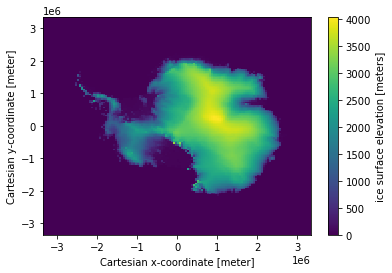

In [4]:
subset = data.isel(x=slice(None, None, 100), y=slice(None, None, 100))
subset.surface.plot()

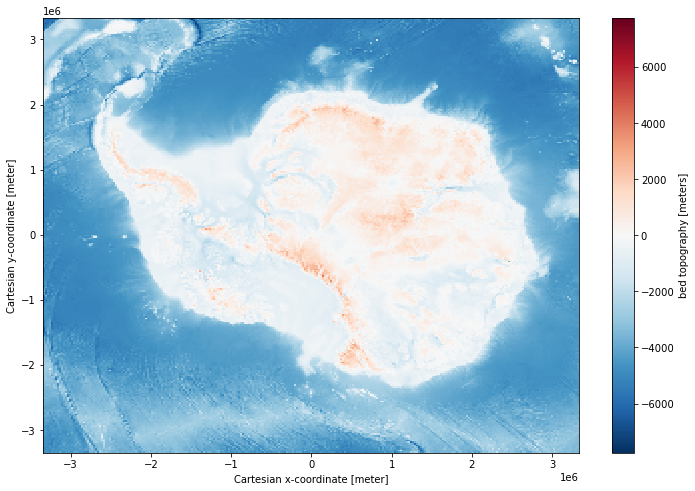

In [5]:
data.bed.isel(x=s_[0::50], y=s_[0::50]).plot(size=8);

In [6]:
source_crs = 'epsg:3031' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system

polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)

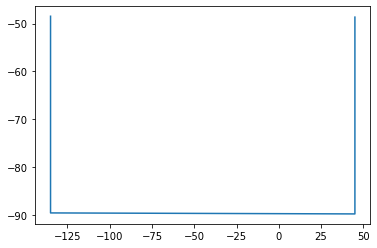

In [7]:
lat, lon = polar_to_latlon.transform(subset.x, subset.y)
plt.plot(lon, lat)

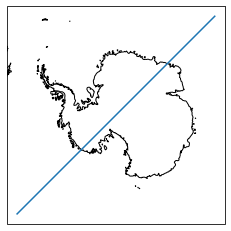

In [8]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.plot(lon, lat, transform=ccrs.PlateCarree())
ax.coastlines()

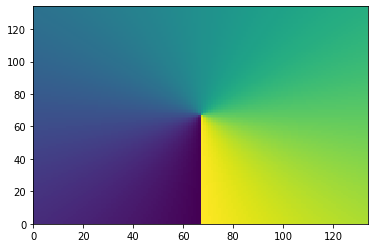

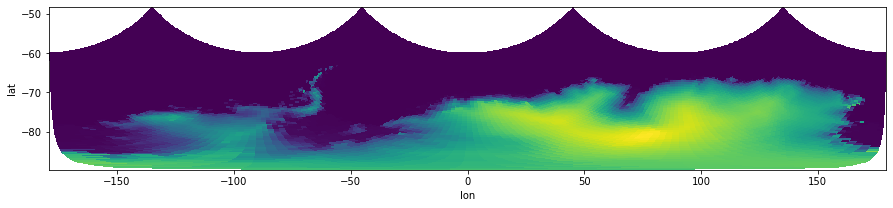

In [9]:
X, Y = numpy.meshgrid(subset.x, subset.y)
lat, lon = polar_to_latlon.transform(X, Y)

plt.pcolormesh(lon)
subset.coords['lat'] = (subset.surface.dims, lat)
subset.coords['lon'] = (subset.surface.dims, lon)

subset.surface
plt.figure(figsize=(15,3))
subset.surface.plot.pcolormesh('lon', 'lat', add_colorbar=False)

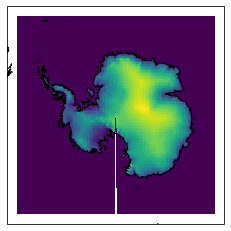

In [10]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
subset.surface.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

In [11]:
def lon_lat_box(lon_bounds, lat_bounds, refinement=2):
    """
    Coordinates along the boundary of a rectangle in lat-lon coordinates
    
    Args:
        lon_bounds: (min, max) lon values
        lat_bounds: (min, max) lat values
        refinement: number of points to draw along each edge
        
    Returns: (lons, lats)
    """
    lons = []
    lats = []
    
    lons.append(numpy.linspace(lon_bounds[0], lon_bounds[-1], num=refinement))
    lats.append(numpy.linspace(lat_bounds[0], lat_bounds[0], num=refinement))
                
    lons.append(numpy.linspace(lon_bounds[-1], lon_bounds[-1], num=refinement))
    lats.append(numpy.linspace(lat_bounds[0], lat_bounds[-1], num=refinement))
                
    lons.append(numpy.linspace(lon_bounds[-1], lon_bounds[0], num=refinement))
    lats.append(numpy.linspace(lat_bounds[-1], lat_bounds[-1], num=refinement))
    
    lons.append(numpy.linspace(lon_bounds[0], lon_bounds[0], num=refinement))
    lats.append(numpy.linspace(lat_bounds[-1], lat_bounds[0], num=refinement))
    
    return numpy.concatenate(lons), numpy.concatenate(lats)

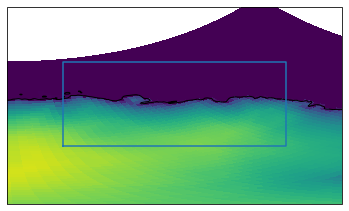

In [12]:
boxlon, boxlat = lon_lat_box([100,140],[-75,-60], refinement=100)

ax = plt.axes(projection=ccrs.PlateCarree())
subset.surface.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.plot(boxlon, boxlat, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([90,150,-85,-50])

In [13]:
polar_to_cart = pyproj.Transformer.from_crs(source_crs, '+proj=geocent')
cX, cY, cZ = polar_to_cart.transform(X, Y, 0*X)

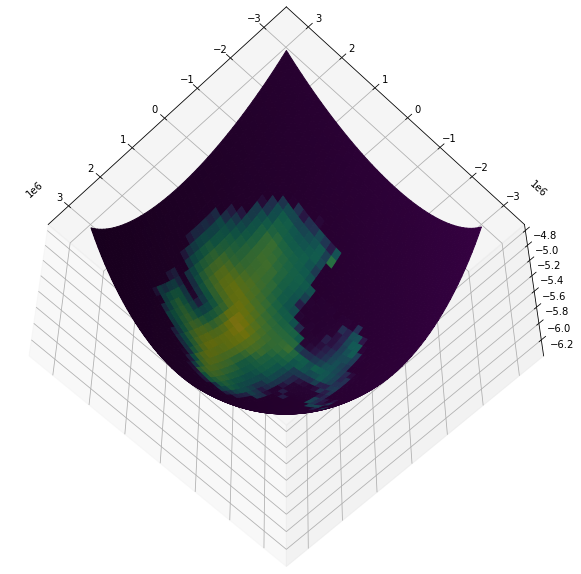

In [14]:
import matplotlib

plt.figure(figsize=(15,10))

# Make a 3d plot
ax = plt.axes(projection='3d')

# Use the values to colour the surface
cmap = plt.cm.ScalarMappable(cmap='viridis')
colors = cmap.to_rgba(subset.surface)

ax.plot_surface(cX, cY, cZ, facecolors=colors)

# Camera position
ax.elev = -60
ax.azim = 135